# Stat-Win Correlation analysis

> by Imt of NYXL (imt@andbox.com)

# Data Preparation

In [1]:
import os
import pandas as pd 
from tqdm import tqdm
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_ind_from_stats

## 0. Preprocess simple PHS files

> Select a new_phs file you want to analyze and make a variable into `phs_name = phs_list[<your file number here>]`

> Here I add `is_match_winner` and `is_map_winner` features into `new_phs` dataframe

In [2]:
# File path of prepared new_phs
path = "./data/"
phs_list = os.listdir(path)
phs_list = [file_name for file_name in phs_list if file_name.endswith(".csv")]

# choose all time or specific season
is_all_time = True # set True if target data is all seasons data

if is_all_time == True:
    li = []
    for phs_name in phs_list:
        new_phs = pd.read_csv(f'{path}{phs_name}')
        li.append(new_phs)
    new_phs = pd.concat(li, axis=0, ignore_index=True)
    all_seasons = True

else:
    phs_name = phs_list[10] # set index of target csv file
    new_phs = pd.read_csv(f'{path}{phs_name}')
    all_seasons = False

# Add 'is_match_winner' feature
def match_winner(df):
    '''
    args, get a dataframe, expected to be phs with selected features
    targets, winner = 1; loser = 0
    '''
    if df['match_winner'] == df['team_name']: #there's 'team' column in 2018 data 
        return 1
    elif df['match_winner'] == 'draw':
        return -1
    else:
        return 0

new_phs['is_match_winner'] = new_phs.apply(match_winner, axis = 1)

# Add 'is_map_winner' feature
def map_winner(df):
    '''
    args, get a dataframe, expected to be phs with selected features
    targets, winner = 1; loser = 0; draw = -1
    '''
    if df['map_winner'] == df['team_name']:
        return 1
    elif df['map_winner'] == 'draw':
        return -1
    else:
        return 0

new_phs['is_map_winner'] = new_phs.apply(map_winner, axis = 1)

## 1. Analyze stats which are important for map winning in target hero

> Compare stat between winner team vs loser team and show significantly different stats

> Define a target hero `target_hero = '<target hero name here>'`. You can also assign 'All Heroes'.

> Plot the normalized stat amounts in bar graph, and color red if the stat's p-value < 0.05

> Results (csv and png files) will be saved into './result/`target_hero`/'

num of stats: 50, num of significantly different stats: 42
significantly different stats: 
['All Damage Done' 'Assists' 'Average Time Alive' 'Barrier Damage Done'
 'Critical Hit Accuracy' 'Critical Hit Kills' 'Critical Hits'
 'Damage - Pulse Bomb' 'Damage - Quick Melee' 'Damage - Weapon' 'Deaths'
 'Eliminations' 'Eliminations per Life' 'Final Blows' 'Healing Received'
 'Health Recovered' 'Hero Damage Done' 'Match Blinks Used'
 'Melee Final Blows' 'Objective Kills' 'Objective Time'
 'Pulse Bomb Efficiency' 'Pulse Bomb Kills' 'Pulse Bombs Attached'
 'Quick Melee Hits' 'Quick Melee Ticks' 'Recalls Used'
 'Secondary Fire Accuracy' 'Self Healing'
 'Self Healing Percent of Damage Taken' 'Shots Fired' 'Shots Hit'
 'Shots Missed' 'Solo Kills' 'Time Alive' 'Time Building Ultimate'
 'Time Elapsed per Ultimate Earned' 'Time Holding Ultimate' 'Time Played'
 'Ultimates Earned - Fractional' 'Ultimates Used' 'Weapon Accuracy']


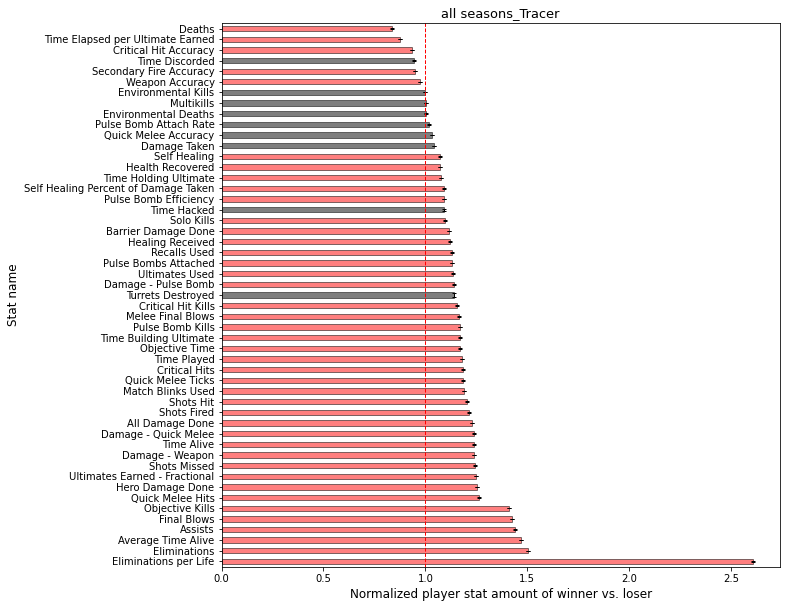

In [19]:
## Compare stat of All Heroes
target_hero = 'Tracer'
target_phs = new_phs[new_phs['hero_name'] == target_hero]

grouped = target_phs.groupby(by=['stat_name', 'is_map_winner'])['stat_amount'].agg(['mean', 'std', 'count', 'sem'])
grouped = grouped.unstack()
grouped

# Add normalized average and s.e.m.
def norm_func(df):
    df['norm_avg'] = (df[('mean', 1)] / df[('mean', 0)])
    df['norm_sem'] = (df[('sem', 1)] / df[('mean', 0)])
    return df

grouped = grouped.apply(norm_func, axis = 1)

# Add t-test values (t-value, p-value)
def ttest_func(df):
    t, p = ttest_ind_from_stats(df[('mean', 0)], df[('std', 0)], df[('count', 0)], df[('mean', 1)], df[('std', 1)], df[('count', 1)], equal_var=True)
    df['tval'] = t
    df['pval'] = p
    return df

grouped = grouped.apply(ttest_func, axis = 1)

# Describe statistical significance
sig_stats = grouped[grouped['pval'] < 0.05].index.values
print(f"num of stats: {grouped['pval'].count()}, num of significantly different stats: {grouped[grouped['pval'] < 0.05]['pval'].count()}")
print(f'significantly different stats: \n{sig_stats}')


# Visualization
# Sorting
sortby = 'norm_avg' # sorting params ('norm_avg', 'pval' ...)
grouped.sort_values(by = [sortby], axis = 0, ascending = False, inplace = True)

# Add color for highlight p-value
color = list()
for p in grouped['pval']:
    if p<0.05:
        color.append('red')
    else:
        color.append('black')

grouped['norm_avg'].plot(kind='barh', yerr=grouped['norm_sem'], figsize=(10,10), color=color, alpha=0.5, edgecolor='black', linewidth=1, error_kw={'ecolor':'black', 'elinewidth':1, 'capsize':2})
plt.axvline(1, 0, 1, color='red', linestyle='--', linewidth='1')

# Add graph info
if all_seasons == True:
    title = 'all seasons' # for integrated analysis
    title = title + f'_{target_hero}'
else:
    title = phs_name.lstrip('new_phs_') # refine title
    title = title.rstrip('.csv') # refine title
    title = title.replace('_', ' ') # refine title
    title = title + f'_{target_hero}'

plt.title(title, fontsize=13)
plt.xlabel('Normalized player stat amount of winner vs. loser', fontsize=12)
plt.ylabel('Stat name', fontsize=12)

# Save dataframe and img
save_path = f'./result/{target_hero}/'
os.makedirs(save_path, exist_ok=True)
grouped.to_csv(f'{save_path}{title}.csv')
plt.savefig(f'{save_path}{title}_aligned by {sortby}.png', bbox_inches='tight')

## 2. Feature Engineering

In [20]:
# Data collection
df = new_phs[['esports_match_id', 'player_name', 'team_name', 'map_name', 'stat_name', 'hero_name', 'stat_amount', 'is_map_winner']]
target_hero = target_hero
df = df[df['hero_name'] == target_hero]
df['is_map_winner'].dropna(axis=0, inplace=True) # drop nan values
df.drop(df[df['is_map_winner'] == -1].index , inplace=True) # drop draw

df = df.groupby(['esports_match_id', 'player_name', 'is_map_winner', 'map_name', 'stat_name'])[['stat_amount', 'is_map_winner']].mean()
df = df.unstack()

# y = df[('is_map_winner', 'Time Played')]
df = df.xs('stat_amount', level=0, axis=1)#.xs(10223, level=0)

# Remove irrelevant features
remove_feature = ['Average Time Alive', 'Damage Done', 'Knockback Kills', 'Teleporter Pads Destroyed', 'Time Alive', 'Turrets Destroyed', 'Ultimates Earned - Fractional'] # remove features seems to be irrelevant
df = df[df.columns.difference(remove_feature)]

# Data cleansing
df.fillna(0, inplace=True)
df = df.stack()
df = df.groupby(['esports_match_id', 'is_map_winner', 'map_name', 'stat_name']).mean()
df = df.unstack()

# check nan values in df
print(f'nan values in df: {df.isnull().sum().sum()}')
display(df.head()) # combined dataframe

# normalize to map total team average
df_0 = df.xs(0, level=1)
df_1 = df.xs(1, level=1)

df_norm_0 = df_0 / (df_0 + df_1)
df_norm_1 = df_1 / (df_0 + df_1)

df_norm_0.fillna(0, inplace=True) # replace nan value as 0
df_norm_1.fillna(0, inplace=True) # replace nan value as 0

df_norm_0['is_map_winner'] = 0
df_norm_1['is_map_winner'] = 1

df_norm = pd.concat([df_norm_0, df_norm_1], axis=0, ignore_index=True)

# check nan value in df_norm
print(f'num nan values in df_norm: {df_norm.isnull().sum().sum()}')
display(df_norm)

# normalize to 10 min average
df_10min = df[df.columns.difference(['is_map_winner'])].div(df['Time Played'], axis=0)
df_10min = df_10min * 600 # 10 min avg

print(f'num nan values in df_10min: {df_10min.isnull().sum().sum()}')
display(df_10min)

# Data transform
# normalized to total team average
X_norm = df_norm[df_norm.columns.difference(['is_map_winner'])] # input data
y_norm = df_norm['is_map_winner'] # target data

# real y and X
df_0['is_map_winner'] = 0
df_1['is_map_winner'] = 1
df = pd.concat([df_0, df_1], axis=0, ignore_index=True)
X_real = df[df.columns.difference(['is_map_winner'])]
y_real = df['is_map_winner']

# normalized to 10 min average
X_10min = df_10min
y_10min = df['is_map_winner']

# Select X, y data type
'''
0: real
1: norm team
2: 10min
'''
# save data type here
data_type = list()
data_type.append([X_real, y_real])
data_type.append([X_norm, y_norm])
data_type.append([X_10min, y_10min])

X, y = data_type[1] # select data type with index

nan values in df: 0


stat_name                                        All Damage Done  Assists  \
esports_match_id is_map_winner map_name                                     
10223            0             Dorado                6763.098879     10.0   
                               Ilios                13727.228860     10.0   
                               Numbani              11104.109260      6.0   
                               Temple of Anubis     16254.241610     18.0   
                 1             Dorado               14648.537490     16.0   

stat_name                                        Barrier Damage Done  \
esports_match_id is_map_winner map_name                                
10223            0             Dorado                    1172.247569   
                               Ilios                     1856.374260   
                               Numbani                   1265.934213   
                               Temple of Anubis          2907.076835   
                 1             Dorado                    3361.396517   

stat_name                                        Critical Hit Accuracy  \
esports_match_id is_map_winner map_name                                  
10223            0             Dorado                         0.077801   
                               Ilios                          0.065154   
                               Numbani                        0.090734   
                               Temple of Anubis               0.066511   
                 1             Dorado                         0.059518   

stat_name                                        Critical Hit Kills  \
esports_match_id is_map_winner map_name                               
10223            0             Dorado                           0.0   
                               Ilios                            2.0   
                               Numbani                          0.0   
                               Temple of Anubis                 2.0   
                 1             Dorado                           1.0   

stat_name                                        Critical Hits  \
esports_match_id is_map_winner map_name                          
10223            0             Dorado                     75.0   
                               Ilios                     135.0   
                               Numbani                   141.0   
                               Temple of Anubis          171.0   
                 1             Dorado                    126.0   

stat_name                                        Damage - Pulse Bomb  \
esports_match_id is_map_winner map_name                                
10223            0             Dorado                     840.980041   
                               Ilios                     1945.101196   
                               Numbani                   1480.171852   
                               Temple of Anubis          1433.149376   
                 1             Dorado                    1583.580002   

stat_name                                        Damage - Quick Melee  \
esports_match_id is_map_winner map_name                                 
10223            0             Dorado                      398.085524   
                               Ilios                       470.000000   
                               Numbani                     537.498318   
                               Temple of Anubis            603.299981   
                 1             Dorado                      134.000000   

stat_name                                        Damage - Weapon  \
esports_match_id is_map_winner map_name                            
10223            0             Dorado                4348.105745   
                               Ilios                 9358.853336   
                               Numbani               7817.614874   
                               Temple of Anubis     11272.961030   
                 1             Dorado             

num nan values in df_norm: 0


stat_name,All Damage Done,Assists,Barrier Damage Done,Critical Hit Accuracy,Critical Hit Kills,Critical Hits,Damage - Pulse Bomb,Damage - Quick Melee,Damage - Weapon,Damage Taken,...,Solo Kills,Time Building Ultimate,Time Discorded,Time Elapsed per Ultimate Earned,Time Hacked,Time Holding Ultimate,Time Played,Ultimates Used,Weapon Accuracy,is_map_winner
0,0.315861,0.384615,0.258566,0.566570,0.000000,0.373134,0.346859,0.748161,0.313181,0.319676,...,0.000000,0.285859,0.0,0.483496,0.0,0.582116,0.327863,0.250000,0.465048,0
1,0.667331,0.540541,0.524705,0.431978,1.000000,0.671642,0.716794,0.786272,0.692246,0.669990,...,0.800000,0.657175,0.0,0.491402,0.0,0.693141,0.666667,0.700000,0.542808,0
2,0.461197,0.300000,0.396461,0.538914,0.000000,0.481229,0.660259,0.693799,0.437847,0.491365,...,0.571429,0.492052,0.0,0.538686,0.0,0.541782,0.500000,0.470588,0.511662,0
3,0.745142,0.765957,0.720168,0.400940,0.571429,0.726115,0.637746,0.765954,0.770210,0.735056,...,1.000000,0.805866,0.0,0.545898,0.0,0.799097,0.805109,0.800000,0.522562,0
4,0.823530,0.500000,0.910583,0.616487,0.000000,0.875000,1.000000,1.000000,0.785779,0.859559,...,0.000000,0.833651,0.0,0.571126,0.0,0.952191,0.854229,1.000000,0.471595,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5273,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1
5274,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1
5275,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1
5276,0.330309,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.549635,0.000000,...,0.000000,0.235016,0.0,0.279995,0.0,0.000000,0.216311,0.000000,0.646154,1


num nan values in df_10min: 732


stat_name                                        All Damage Done    Assists  \
esports_match_id is_map_winner map_name                                       
10223            0             Dorado               11081.777061  16.385650   
                               Ilios                11357.029973   8.273360   
                               Numbani              10168.466929   5.494435   
                               Temple of Anubis      9180.452371  10.166463   
                 1             Dorado               11708.281843  12.788479   
...                                                          ...        ...   
35554            0             Busan                 5825.784185   1.781443   
                               King's Row            4101.485159   0.000000   
                               Temple of Anubis         0.000000   0.000000   
                 1             King's Row            7329.129479   0.000000   
                               Temple of Anubis      8921.682220   0.000000   

stat_name                                        Barrier Damage Done  \
esports_match_id is_map_winner map_name                                
10223            0             Dorado                    1920.803829   
                               Ilios                     1535.845168   
                               Numbani                   1159.265446   
                               Temple of Anubis          1641.927139   
                 1             Dorado                    2686.696732   
...                                                              ...   
35554            0             Busan                      192.317512   
                               King's Row                2422.638902   
                               Temple of Anubis             0.000000   
                 1             King's Row                   0.000000   
                               Temple of Anubis          1286.394558   

stat_name                                        Critical Hit Accuracy  \
esports_match_id is_map_winner map_name                                  
10223            0             Dorado                         0.127482   
                               Ilios                          0.053905   
                               Numbani                        0.083088   
                               Temple of Anubis               0.037566   
                 1             Dorado                         0.047572   
...                                                                ...   
35554            0             Busan                          0.224491   
                               King's Row                     0.000000   
                               Temple of Anubis               0.000000   
                 1             King's Row                     0.000000   
                               Temple of Anubis               0.650483   

stat_name                                        Critical Hit Kills  \
esports_match_id is_map_winner map_name                               
10223            0             Dorado                      0.000000   
                               Ilios                       1.654672   
                               Numbani                     0.000000   
                               Temple of Anubis            1.129607   
                 1             Dorado                      0.799280   
...                                                             ...   
35554            0             Busan                       0.000000   
                               King's Row                  0.000000   
                               Temple of Anubis            0.000000   
                 1             King's Row                  0.000000   
                               Temple of Anubis            0.000000   

stat_name                                        Critical Hits  \
esports_match_id is_map_winner map_name                          
10223           

# Data Modeling

In [21]:
# Import pakages for machine learning

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import lightgbm as lgb

from keras.models import Sequential
from keras.layers import Dense

## 1. Logistic Regression

(4222, 47) (1056, 47) (4222,) (1056,)
Accuracy: 0.67


,cols,abs_coef
38,Solo Kills,0.002722
40,Time Discorded,0.003801
42,Time Hacked,0.009701
6,Damage - Pulse Bomb,0.020672
2,Barrier Damage Done,0.024153


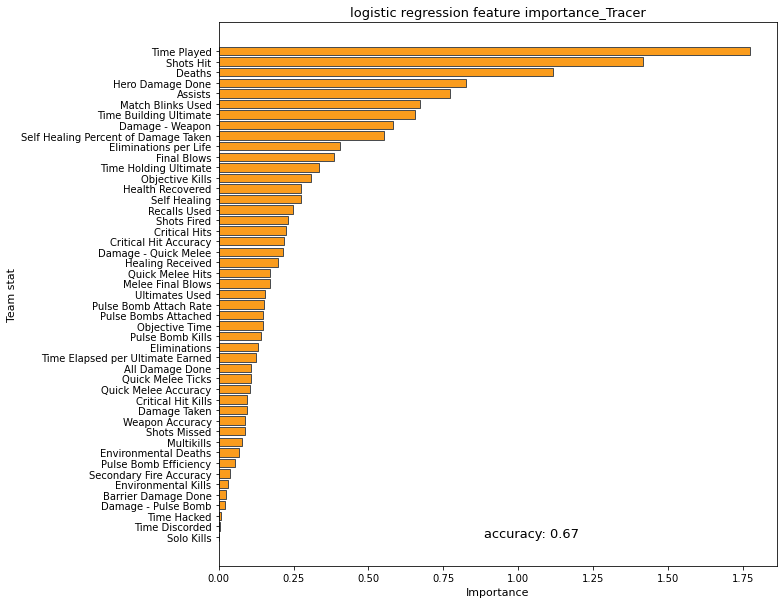

In [22]:
# Set train, validation and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

feature_names = X_train.columns

# Normalize the value with StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Create the logistic regression model
log = LogisticRegression()
log_fit = log.fit(X_train, y_train)

# Accuracy
accuracy = log.score(X_test, y_test)
accuracy = format(accuracy, '.2f')
print(f'Accuracy: {accuracy}')

# Get feature coefficient
coef = log.coef_[0]
abs_coef = abs(coef)

# summarize feature coefficient
fea_rank_ = pd.DataFrame({'cols': feature_names, 'abs_coef': abs_coef})
fea_rank_.sort_values(by=['abs_coef'], ascending = True, inplace=True)

display(fea_rank_.head())

# Plot feature coefficient
title = f'logistic regression feature importance_{target_hero}'
plt.figure(figsize=(10,10))
plt.barh(fea_rank_['cols'], fea_rank_['abs_coef'], facecolor='#FA9C1D', alpha=1, edgecolor='#4A4C4E', linewidth=1)
plt.title(title, fontsize=13)
plt.ylabel('Team stat', fontsize=11)
plt.xlabel('Importance', fontsize=11)

plt.text(x=max(fea_rank_['abs_coef'])/2, y=min(fea_rank_.index), s=f'accuracy: {accuracy}', fontsize=13)

# Save csv and figure
save_path = f'./result/{target_hero}/'
os.makedirs(save_path, exist_ok=True)
fea_rank_.to_csv(f'{save_path}{title}.csv')
plt.savefig(f'{save_path}{title}.png', bbox_inches='tight')

Accuracy: 0.66
[False  True False False False False False False  True False  True False
 False False False  True False False  True  True False False False False
 False False False False False False False False False False False False
  True False False  True False False False  True  True False False]


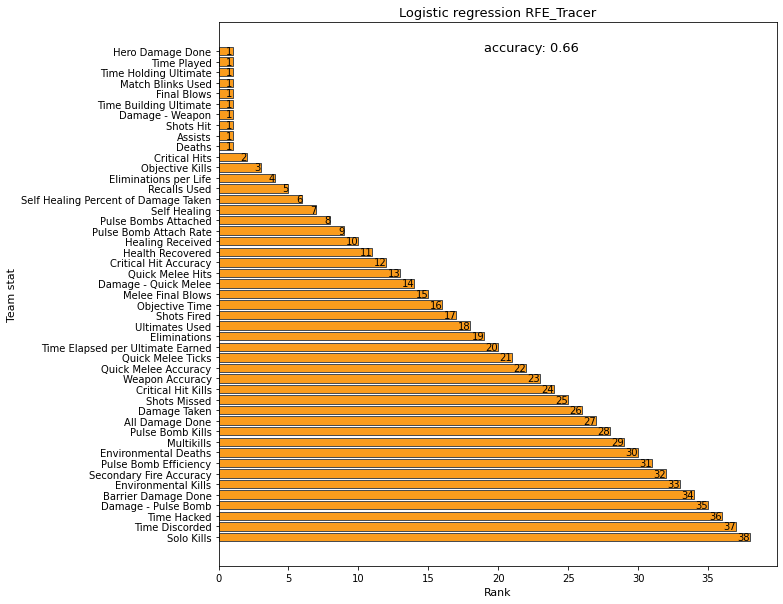

In [23]:
#Recursive Feature Elimination(RFE)

# create the RFE model
rfe = RFE(estimator=log, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

# Accuracy
y_pred = rfe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy = format(accuracy, '.2f')
print(f'Accuracy: {accuracy}')

# summarize the selection of the attributes
print(rfe.support_)

# summarize the ranking of the attributes
fea_rank_ = pd.DataFrame({'cols': feature_names, 'fea_rank': rfe.ranking_})
fea_rank_ = fea_rank_.loc[fea_rank_.fea_rank > 0].sort_values(by=['fea_rank'], ascending=False)

# Plot feature importance
title = f'Logistic regression RFE_{target_hero}'
plt.figure(figsize=(10,10))
plt.barh(fea_rank_['cols'], fea_rank_['fea_rank'], facecolor='#FA9C1D', alpha=1, edgecolor='#4A4C4E', linewidth=1)
plt.title(title, fontsize=13)
plt.ylabel('Team stat', fontsize=11)
plt.xlabel('Rank', fontsize=11)

for i in fea_rank_.index: # add values on bar graph
   plt.text(fea_rank_.loc[i, 'fea_rank'], fea_rank_.loc[i, 'cols'], fea_rank_.loc[i, 'fea_rank'],
   horizontalalignment='right', 
   verticalalignment='center')

plt.text(x=max(fea_rank_['fea_rank'])/2, y=max(fea_rank_.index), s=f'accuracy: {accuracy}', fontsize=13)

# Save csv and figure
save_path = f'./result/{target_hero}/'
os.makedirs(save_path, exist_ok=True)
fea_rank_.to_csv(f'{save_path}{title}.csv')
plt.savefig(f'{save_path}{title}.png', bbox_inches='tight')

## 2. LightGBM classification

(3377, 47) (1056, 47) (3377,) (1056,)
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Accuracy: 0.67


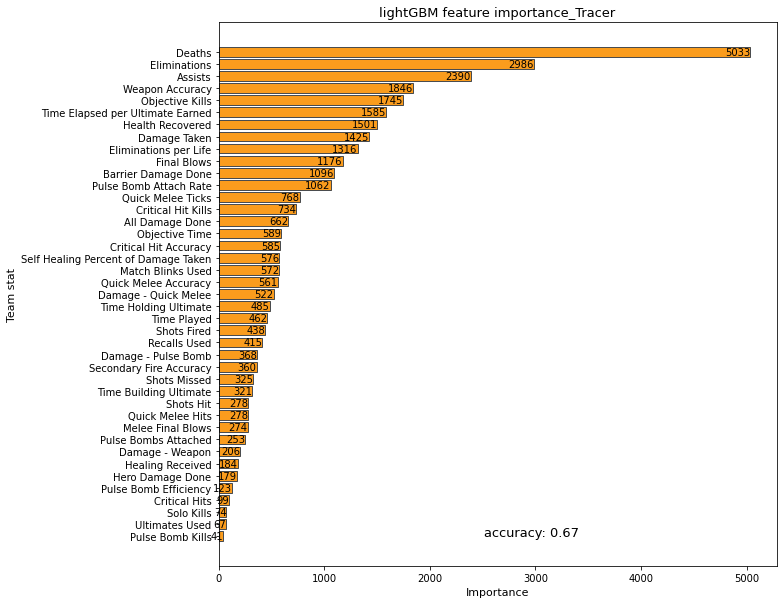

In [24]:
# LightGBM 
'''
note: https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/
'''
# set train, validation and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2) # validation set

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

feature_names = X_train.columns

# Normalize the value with StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# create the lightGBM model
lgbm = lgb.LGBMClassifier(
   objective='binary', 
   boosting_type='gbdt', # gbdt(gradient boosting decision tree), rf(random forest), dart(dropouts meet multiple additive regression trees), goss(Gradient-based One-Side Sampling)
   learning_rate=0.001,
   n_estimators=500,
   num_boost_round=2000,
   )

lgbm.fit(
   X_train, y_train,
   eval_metric='binary_logloss',
   eval_set=(X_val, y_val),
   early_stopping_rounds=500,
   verbose=False
   )

lgbm.booster_.feature_importance()

# Accuracy
accuracy = lgbm.score(X_test, y_test)
accuracy = format(accuracy, '.2f')
print(f'Accuracy: {accuracy}')

# importance of each attribute
fea_imp_ = pd.DataFrame({'cols': feature_names, 'fea_imp': lgbm.feature_importances_})
fea_imp_ = fea_imp_.loc[fea_imp_.fea_imp > 0].sort_values(by=['fea_imp'], ascending=True)

# Plot feature importance
title = f'lightGBM feature importance_{target_hero}'
plt.figure(figsize=(10,10))
plt.barh(fea_imp_['cols'], fea_imp_['fea_imp'], facecolor='#FA9C1D', alpha=1, edgecolor='#4A4C4E', linewidth=1)
plt.title(title, fontsize=13)
plt.ylabel('Team stat', fontsize=11)
plt.xlabel('Importance', fontsize=11)
for i in fea_imp_.index: # add values on bar graph
   plt.text(fea_imp_.loc[i, 'fea_imp'], fea_imp_.loc[i, 'cols'], fea_imp_.loc[i, 'fea_imp'],
   horizontalalignment='right', 
   verticalalignment='center')

plt.text(x=max(fea_imp_['fea_imp'])/2, y=min(fea_imp_.index), s=f'accuracy: {accuracy}', fontsize=13)

# Save csv and figure
save_path = f'./result/{target_hero}/'
os.makedirs(save_path, exist_ok=True)
fea_imp_.to_csv(f'{save_path}{title}.csv')
plt.savefig(f'{save_path}{title}.png', bbox_inches='tight')

[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Accuracy: 0.67
[False  True False False False False False False False  True  True  True
 False False False  True False  True False False False False False  True
 False False False False False False False False False False False  True
 False False False False False  True False False False False  True]


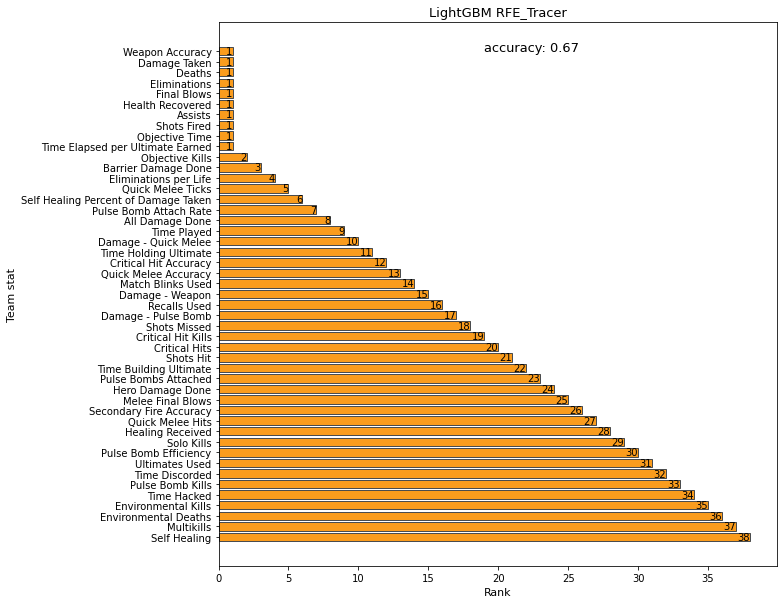

In [25]:
#Recursive Feature Elimination(RFE)

# create the RFE model
rfe = RFE(estimator=lgbm, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

# Accuracy
y_pred = rfe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy = format(accuracy, '.2f')
print(f'Accuracy: {accuracy}')

# summarize the selection of the attributes
print(rfe.support_)

# summarize the ranking of the attributes
fea_rank_ = pd.DataFrame({'cols': feature_names, 'fea_rank': rfe.ranking_})
fea_rank_ = fea_rank_.loc[fea_rank_.fea_rank > 0].sort_values(by=['fea_rank'], ascending = False)

# Plot feature importance
title = f'LightGBM RFE_{target_hero}'
plt.figure(figsize=(10,10))
plt.barh(fea_rank_['cols'], fea_rank_['fea_rank'], facecolor='#FA9C1D', alpha=1, edgecolor='#4A4C4E', linewidth=1)
plt.title(title, fontsize=13)
plt.ylabel('Team stat', fontsize=11)
plt.xlabel('Rank', fontsize=11)
for i in fea_rank_.index: # add values on bar graph
   plt.text(fea_rank_.loc[i, 'fea_rank'], fea_rank_.loc[i, 'cols'], fea_rank_.loc[i, 'fea_rank'],
   horizontalalignment='right', 
   verticalalignment='center')

plt.text(x=max(fea_rank_['fea_rank'])/2, y=max(fea_rank_.index), s=f'accuracy: {accuracy}', fontsize=13)

# Save csv and figure
save_path = f'./result/{target_hero}/'
os.makedirs(save_path, exist_ok=True)
fea_rank_.to_csv(f'{save_path}{title}.csv')
plt.savefig(f'{save_path}{title}.png', bbox_inches='tight')

## 3. Deep neural network

(4222, 47) (1056, 47) (4222,) (1056,)
47


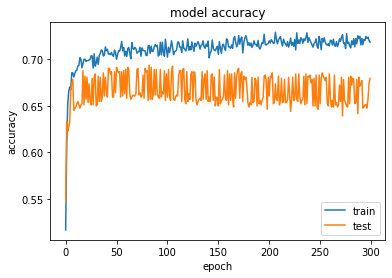

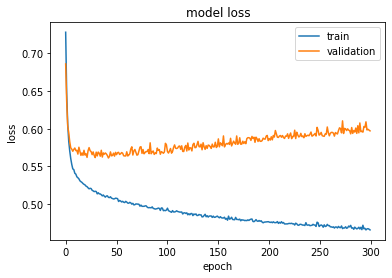

33/33 [==============================] - 0s 813us/step - loss: 0.6196 - accuracy: 0.6506


[0.619618833065033, 0.6505681872367859]

In [26]:
# Set train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
num_input_node = len(X_train.columns)
print(num_input_node)

# Normalize the value with StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Setup a model
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(num_input_node,)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split=0.2, epochs=300, verbose=0)

# Plot model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# Plot model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Evaluate the model
eval = model.evaluate(x=X_test, y=y_test)
eval
